In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

import cartopy.crs as ccrs
from scipy.stats import spearmanr

import matplotlib

import geopandas as gpd

import warnings

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
make_train_pred_scatterplot as make_scatterplot, cv_solve, solver_kwargs, get_truth_preds_from_kfold_results,
                             predict_y_from_kfold_dict, generalized_demean)


import rasterio
import rasterio.mask
from rasterio import warp

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In this notebook we will predicted mean VIIRS nightlight luminosity at the ADM2 level, using a model trained at the ADM1 level.



In [3]:
df = pd.read_pickle(data_dir + "preds/nl_adm2_preds_recenter=adm0_dropIreland=True_extra_clip=False")

In [4]:
sklearn.metrics.r2_score(df["truth"],df["preds"])

0.7002460517466496

In [5]:
n = len(df.dropna())

In [6]:
adm2_shp = gpd.read_file(data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson")
adm2_shp = adm2_shp.to_crs("ESRI:54030")

In [7]:
adm2_shp = adm2_shp.merge(df,on="shapeID")

In [8]:
country_shp = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_ADM0_dissolved_shapefile.p")
country_shp = country_shp.to_crs("ESRI:54030")

In [9]:
## Libya is missing from the ADM2 shapefile so we add it back in for aesthetics
LBY = country_shp.loc[["LBY"]]
LBY["val"] = 0

In [10]:
cmap = "gist_heat"
#rasterized = True
rasterized = True
linewidth = 0

In [11]:
df =df.fillna(0) # fill in dropped obs for plotting purposes only

In [12]:
from shapely.geometry.point import Point as Point

In [13]:
gdf = gpd.GeoDataFrame({"geometry": [Point([-160,-44])]})

In [14]:
gdf.crs = "EPSG:4326"

In [15]:
gdf.to_crs("ESRI:54030")

,geometry
0,POINT (-13627719.310 -4699790.486)


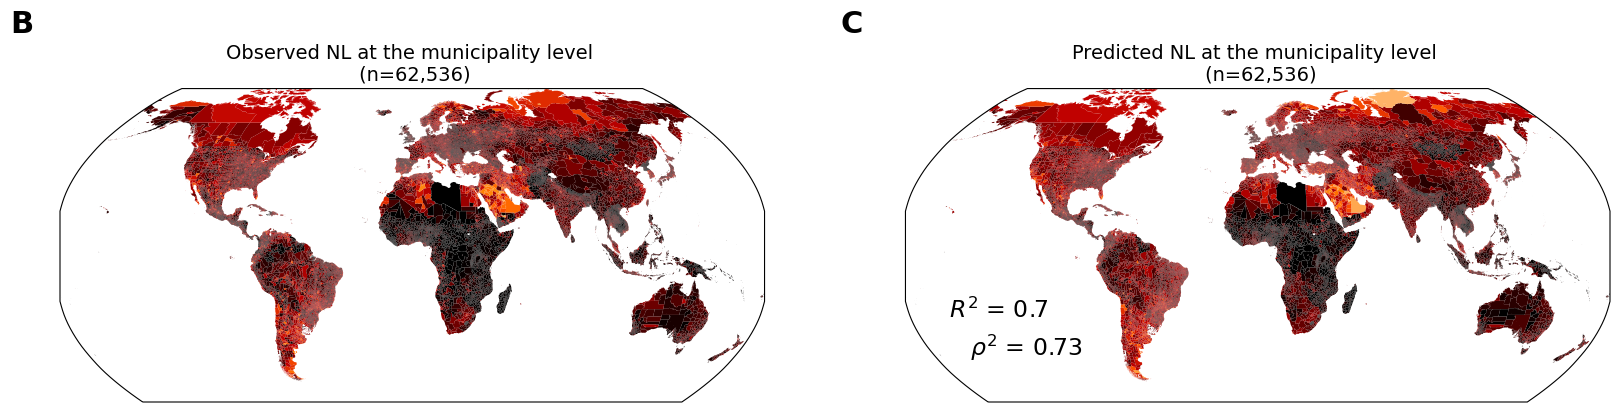

In [16]:
fig, ax  = plt.subplots(1,2, figsize=(20,6), subplot_kw={'projection':ccrs.Robinson()})

vmin = np.min(adm2_shp["truth"])
vmax = np.max(adm2_shp["truth"])

adm2_shp.plot(ax=ax[0],column="truth", cmap=cmap, vmin = vmin, vmax=vmax, 
              rasterized=rasterized, linewidth = linewidth )

adm2_shp.plot(ax=ax[1],column="preds", cmap=cmap, vmin = vmin, vmax=vmax,
              rasterized=rasterized, linewidth=linewidth )

LBY.plot(ax=ax[0],column="val", cmap=cmap, vmin = vmin, vmax=vmax, 
         rasterized=rasterized, linewidth=linewidth )

LBY.plot(ax=ax[1],column="val", cmap=cmap, vmin = vmin, vmax=vmax, 
         rasterized=rasterized, linewidth=linewidth )

r2 = sklearn.metrics.r2_score(df["truth"], df["preds"]).round(2)
r = (np.corrcoef(df["truth"], df["preds"])[0,1] ** 2).round(2)

ax[1].text(-14637734.785, -2887684.634, r"$R^2$ = " + str(r2), size=17)
ax[1].text(-13627719.310, -4699790.486, r"$\rho^2$ = " + str(r), size=17)

ax[0].set_extent((-180,180,-66,78), ccrs.PlateCarree())
ax[1].set_extent((-180,180,-66,78), ccrs.PlateCarree())

ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)

ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)

ax[0].set_title("Observed NL at the municipality level \n (n={:,})".format(n), size=14)
ax[1].set_title("Predicted NL at the municipality level \n (n={:,})".format(n), size=14)

fig.text(.1,.85,"B",size = 22,fontweight='bold',)
fig.text(.515,.85,"C",size = 22,fontweight='bold',)


fig.savefig(repo_dir + "figures/NL_adm1_to_adm2_downscale_centered.pdf", dpi=300)

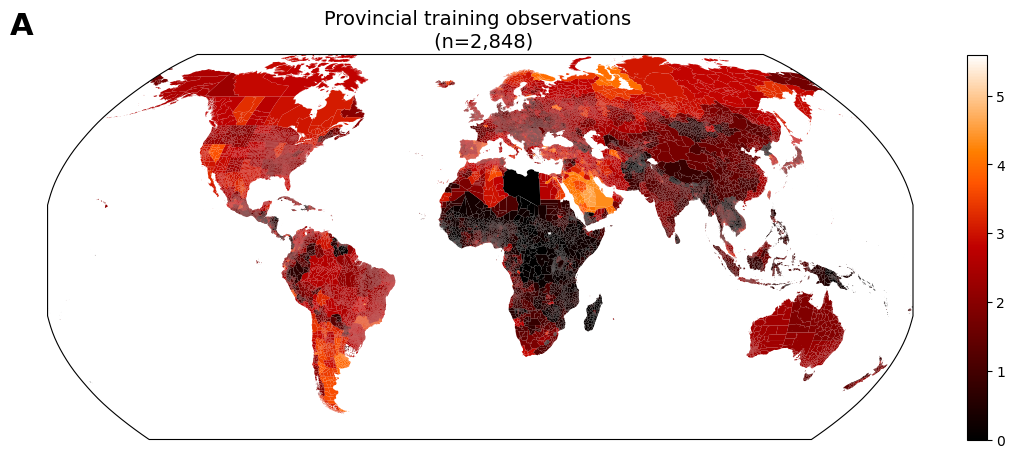

In [17]:
fig, ax = plt.subplots(1, figsize= (14,5), subplot_kw={'projection':ccrs.Robinson()})

adm2_shp.plot(column = "adm1_known",  ax = ax, cmap=cmap, vmin=vmin, vmax=vmax, 
              rasterized=rasterized, linewidth=linewidth, legend=True)

LBY.plot(ax=ax,column="val", cmap=cmap, vmin = vmin, vmax=vmax, 
         rasterized=rasterized, linewidth=linewidth )

ax.set_extent((-180,180,-66,78), ccrs.PlateCarree())


ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.set_title("Provincial training observations \n (n=2,848)",size=14)

fig.text(.1,.92,"A",size = 22,fontweight='bold')

fig.savefig(repo_dir + "figures/NL_adm1_training.pdf", dpi=300)

### Now let's punch-in to a few ADM1 regions

In [18]:
adm1_code = "USA-ADM1-3_0_0-B26" # Texas

In [19]:
adm2_sub = adm2_shp[adm2_shp["ADM1_shape"] == adm1_code]

adm2_sub["true_rank"] = adm2_sub["truth"].rank(ascending=False)
adm2_sub["pred_rank"] = adm2_sub["preds"].rank(ascending=False)

adm2_sub = adm2_sub.to_crs("EPSG:4326")

/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


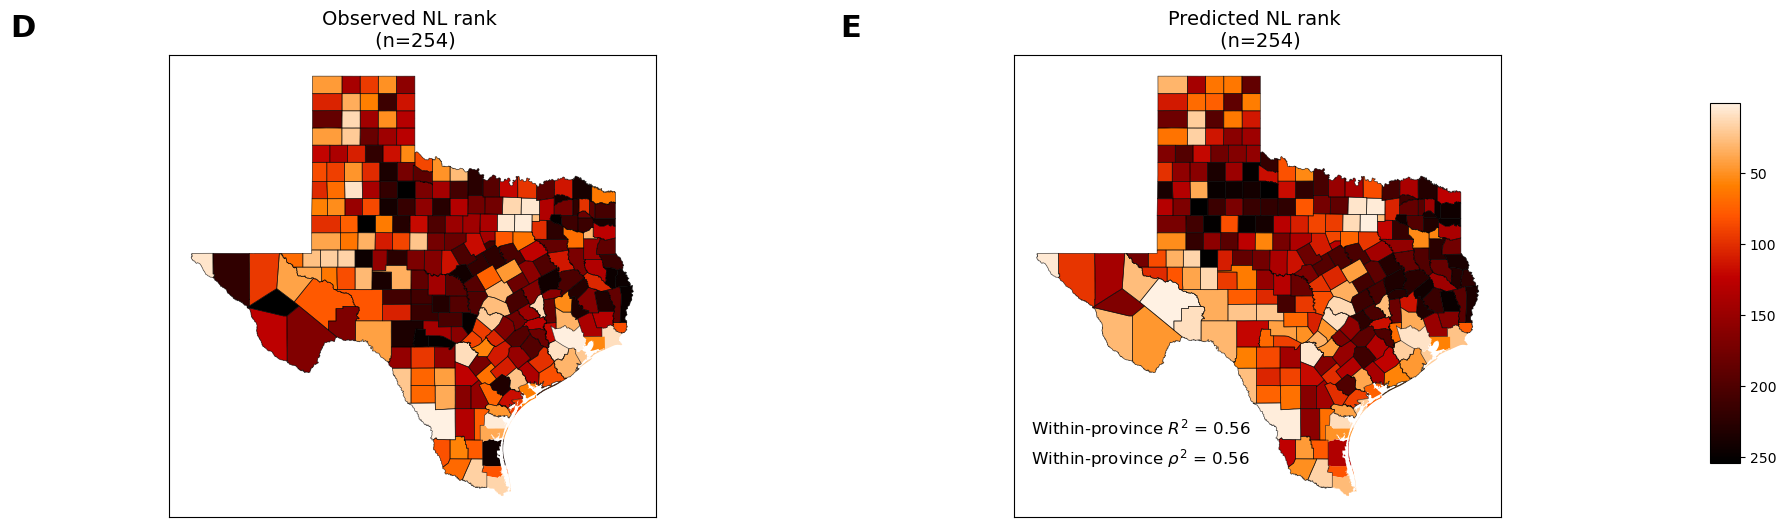

In [20]:
fig, ax  = plt.subplots(1,2, figsize=(20,6))

vmin_r = np.min(adm2_sub["true_rank"]) - len(adm2_sub) * .03
vmax_r = np.max(adm2_sub["true_rank"])

cax = fig.add_axes([.95, 0.2, 0.015, 0.6])
sm = plt.cm.ScalarMappable(cmap=cmap + "_r", norm=plt.Normalize(vmin=vmin_r, vmax=vmax_r))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cax.set_ylim((max(cax.get_ylim()) ),1)
cbr.ax.tick_params(labelsize=10)


adm2_sub.plot(ax=ax[0],column="true_rank", cmap=cmap +"_r", vmin = vmin_r, vmax=vmax_r, legend = False, 
              rasterized=rasterized)
adm2_sub.plot(ax=ax[1],column="pred_rank", cmap=cmap + "_r", vmin = vmin_r, vmax=vmax_r, legend= False,
             rasterized=rasterized)

adm2_sub.exterior.plot(ax=ax[1],color="black", linewidth=.5, alpha=.7)
adm2_sub.exterior.plot(ax=ax[0],color="black", linewidth=.5, alpha=.7)

ax[0].set_title(f"Observed NL rank \n (n={len(adm2_sub)})", size=14)
ax[1].set_title(f"Predicted NL rank \n (n={len(adm2_sub)})", size=14)

ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)

ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)

r2 = sklearn.metrics.r2_score(adm2_sub["truth"],adm2_sub["preds"])
rho = np.corrcoef(adm2_sub["truth"],adm2_sub["preds"])[0,1] ** 2

ax[1].text(-106.8, 26.65, r"Within-province $\rho^2$ = " + str(round(rho,2)), size=12) 
ax[1].text(-106.8, 27.4, r"Within-province $R^2$ = " + str(round(r2,2)), size=12) 

# Uncomment to show levels instead of ranks
# fig, ax  = plt.subplots(1,2, figsize=(20,10))
# adm2_sub.plot(ax=ax[0],column="nl_weighted_avg", cmap=cmap, vmin = vmin, vmax=vmax, legend = True )
# adm2_sub.plot(ax=ax[1],column="predicted_val", cmap=cmap, vmin = vmin, vmax=vmax, legend=True )

# ax[0].xaxis.set_visible(False)
# ax[0].yaxis.set_visible(False)

# ax[1].xaxis.set_visible(False)
# ax[1].yaxis.set_visible(False)

fig.text(.1,.91,"D",size = 22,fontweight='bold',)
fig.text(.515,.91,"E",size = 22,fontweight='bold',)


fig.savefig(repo_dir + "figures/NL_TX_adm1_within.pdf", dpi=300, bbox_inches='tight')

In [21]:
adm1_code = "ETH-ADM1-3_0_0-B8" # adm1_code = "AFG-ADM1-3_0_0-B11" #AFG-- Okay...

In [22]:
adm2_shp["ADM1_shape"] == adm1_code

adm2_sub = adm2_shp[adm2_shp["ADM1_shape"] == adm1_code]

adm2_sub["true_rank"] = adm2_sub["truth"].rank(ascending=False)
adm2_sub["pred_rank"] = adm2_sub["preds"].rank(ascending=False)

adm2_sub = adm2_sub.to_crs("EPSG:4326")

/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


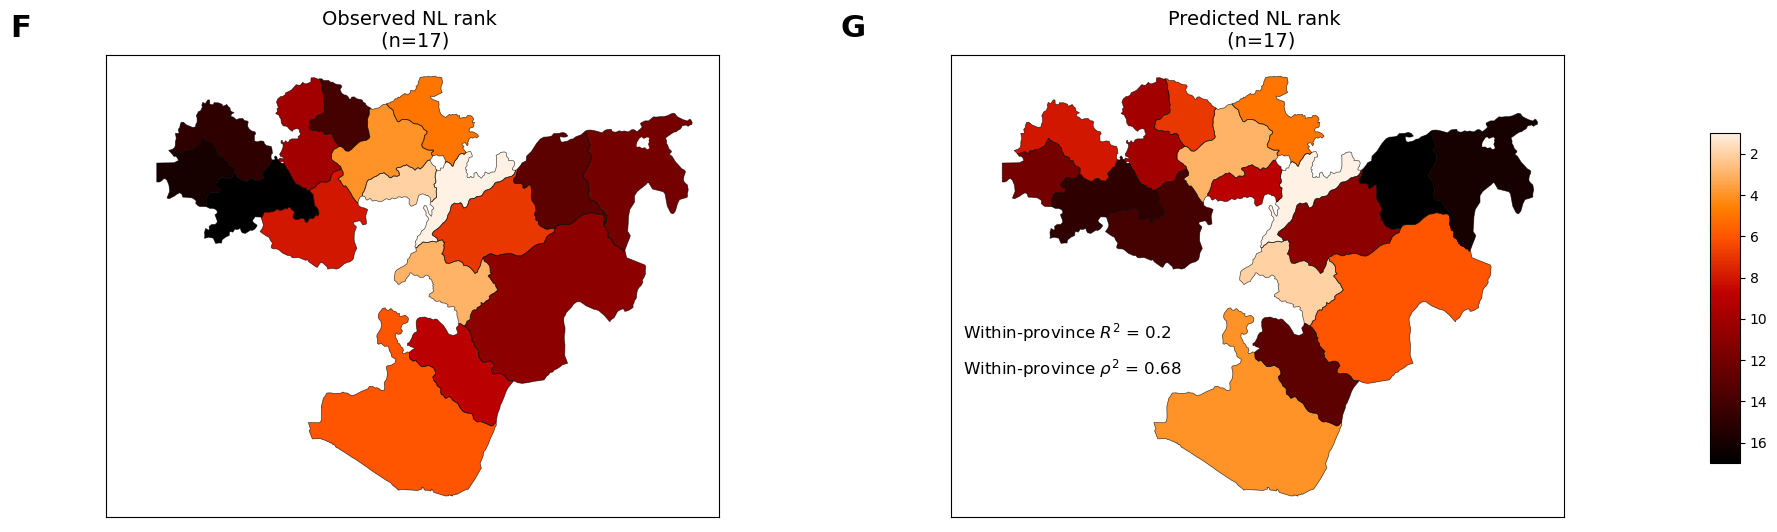

In [23]:
fig, ax  = plt.subplots(1,2, figsize=(20,6))

vmin_r = np.min(adm2_sub["true_rank"]) - len(adm2_sub) * .03
vmax_r = np.max(adm2_sub["true_rank"])

cax = fig.add_axes([.95, 0.2, 0.015, 0.55])
sm = plt.cm.ScalarMappable(cmap=cmap + "_r", norm=plt.Normalize(vmin=vmin_r, vmax=vmax_r))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cax.set_ylim((max(cax.get_ylim()) ),1)
cbr.ax.tick_params(labelsize=10)

adm2_sub.plot(ax=ax[0],column="true_rank", cmap=cmap +"_r", vmin = vmin_r, vmax=vmax_r, legend = False, 
              rasterized=rasterized)
adm2_sub.plot(ax=ax[1],column="pred_rank", cmap=cmap + "_r", vmin = vmin_r, vmax=vmax_r, legend= False,
             rasterized=rasterized)

adm2_sub.exterior.plot(ax=ax[1],color="black", linewidth=.5, alpha=.7)
adm2_sub.exterior.plot(ax=ax[0],color="black", linewidth=.5, alpha=.7)

ax[0].set_title(f"Observed NL rank \n (n={len(adm2_sub)})", size=14)
ax[1].set_title(f"Predicted NL rank \n (n={len(adm2_sub)})", size=14)


ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)

ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)

r2 = sklearn.metrics.r2_score(adm2_sub["truth"],adm2_sub["preds"])
rho = np.corrcoef(adm2_sub["truth"],adm2_sub["preds"])[0,1] ** 2

ax[1].text(33.5, 5.5,r"Within-province $\rho^2$ = " + str(round(rho,2)),size=12)
ax[1].text(33.5, 6.1, r"Within-province $R^2$ = " + str(round(r2,2)),size=12)

ax[0].set_xlim(33.3,None)
ax[1].set_xlim(33.3,None)
# Uncomment to show levels instead of ranks
# fig, ax  = plt.subplots(1,2, figsize=(20,10))
# adm2_sub.plot(ax=ax[0],column="nl_weighted_avg", cmap=cmap, vmin = vmin, vmax=vmax, legend = True )
# adm2_sub.plot(ax=ax[1],column="predicted_val", cmap=cmap, vmin = vmin, vmax=vmax, legend=True )

# ax[0].xaxis.set_visible(False)
# ax[0].yaxis.set_visible(False)

# ax[1].xaxis.set_visible(False)
# ax[1].yaxis.set_visible(False)


fig.text(.1,.91,"F",size = 22,fontweight='bold',)
fig.text(.515,.91,"G",size = 22,fontweight='bold',)

fig.savefig(repo_dir + "figures/NL_ORO_adm1_within.pdf", dpi=300, bbox_inches='tight')